In [1]:
import numpy as np
import math
import scipy.stats as stats

import ROOT as R

from matplotlib import pyplot as plt
from matplotlib import animation

Welcome to JupyROOT 6.18/04


In [2]:
# parameters of the simulation                                                                                                                                  
N = 10000        # number of inhabitants                                                                                                                           
dt = 0.1       # time step (a.u.)
temperature = 2 # mean temperature (a.u) 
size = 300      # size of the town (occupancy = N/size**2)                                                                                                       
frames = int(300/dt)  # duration of the simulation                                                                                                                     
recoT = 10    # mean recovery time gaus(recoT,0.5*recoT)        
P = 0.7      # probability to infect other people at each encounter
deadP = 0.02 # probability to die when infected (die time set extracted from lognormal(2,6))
initialInfected = 0.02 #initial fraction of infected

In [3]:
R.gROOT.ProcessLine(".L epidemics.C+")

0

In [4]:
t={}
temperatures = [0.1,0.5,1,1.5,2.,2.5,3]

for t0 in temperatures:
    t[t0] = R.Town("COVIDVille",N,initialInfected,t0,size,recoT,P,deadP)
    print('======> ' + t[t0]._name + ' temperature {:.1f} infected {:d}'.format(t0,t[t0].nIll()))
#p = t.population()
#size = t.size()

======> COVIDVille temperature 0.1 infected 207
======> COVIDVille temperature 0.5 infected 196
======> COVIDVille temperature 1.0 infected 191
======> COVIDVille temperature 1.5 infected 192
======> COVIDVille temperature 2.0 infected 188
======> COVIDVille temperature 2.5 infected 197
======> COVIDVille temperature 3.0 infected 193


In [5]:
import time

times={}
ills={}
totalInfected={}
totalDeaths={}
totalMeets={}
r={}

for t0 in temperatures:
    times[t0]=[]
    ills[t0]=[]
    totalInfected[t0] = []
    totalDeaths[t0] = []
    totalMeets[t0] = []
    r[t0] = []

    start = time.time()
    for i in range(0,frames):
        t[t0].step(dt)
        times[t0].append((i+1)*dt)
        ills[t0].append(float(t[t0].nIll())/t[t0]._population.size())
        totalInfected[t0].append(1-float(t[t0].nSusceptible())/t[t0]._population.size())
        totalDeaths[t0].append(1-float(t[t0]._population.size())/N)
        totalMeets[t0].append(t[t0].nMeet()/(N*(i+1)*dt)/10.)
        r[t0].append(t[t0].nTransmissionPerInfected())
    #    print('t: {:5d} p: {:6d} p/N: {:3.0f} % i/p: {:5.2f} %'.
    #          format(i, p.size(), p.size()/float(N)*100, float(ills[-1])/p.size()*100))
    end = time.time()
    print("Elapsed time {:.2f}s Total infected {:.2f}".format(end - start,totalInfected[t0][-1]))


Elapsed time 1.62s Total infected 0.05
Elapsed time 1.82s Total infected 0.25
Elapsed time 2.12s Total infected 0.57
Elapsed time 2.04s Total infected 0.77
Elapsed time 2.01s Total infected 0.83
Elapsed time 2.24s Total infected 0.87
Elapsed time 1.97s Total infected 0.90


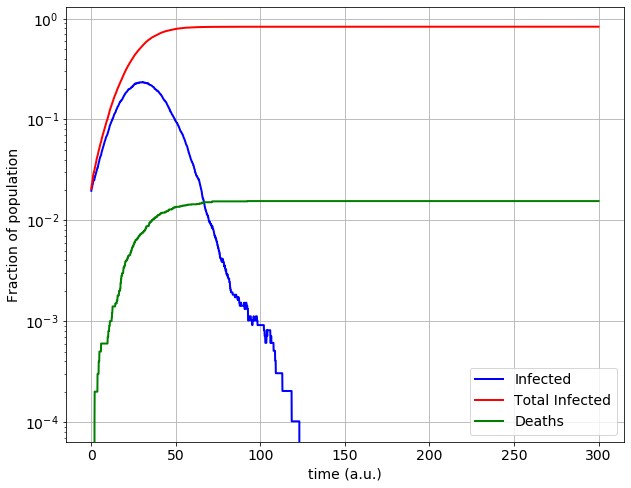

In [6]:
fig = plt.figure(figsize=(10, 8))
plt.rc('font', size=14)
plt.plot(times[2], ills[2], 'b-', lw=2,label='Infected')
plt.plot(times[2], totalInfected[2], 'r-',lw=2,label='Total Infected')
plt.plot(times[2], totalDeaths[2], 'g-',lw=2,label='Deaths')

plt.yscale('log')
plt.grid(True)
plt.legend()
plt.xlabel("time (a.u.)")
plt.ylabel("Fraction of population")
plt.show()

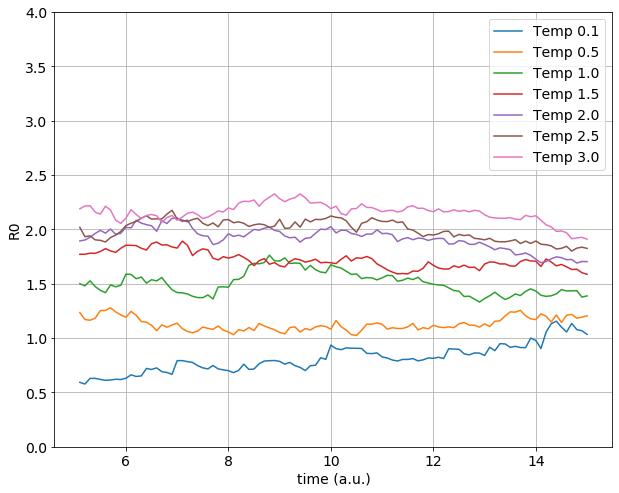

In [25]:
plt.figure(figsize=(10, 8))
r0mean=[]
r0rms=[]
for itemp,t0 in enumerate(temperatures):
    plt.plot(times[t0][int((recoT/dt)*0.5):int(recoT/dt*1.5)],r[t0][int((recoT/dt)*0.5):int(recoT/dt*1.5)],label="Temp {:.1f}".format(t0))
    r0mean.append(np.average(np.asarray(r[t0][int((recoT/dt)*0.5):int(recoT/dt)])))
    r0rms.append(np.std(np.asarray(r[t0][int((recoT/dt)*0.5):int(recoT/dt)])))
#print(r0mean)
plt.legend()
plt.grid(True)
plt.ylim(0.,4.)
plt.xlabel("time (a.u.)")
plt.ylabel("R0")
plt.show()

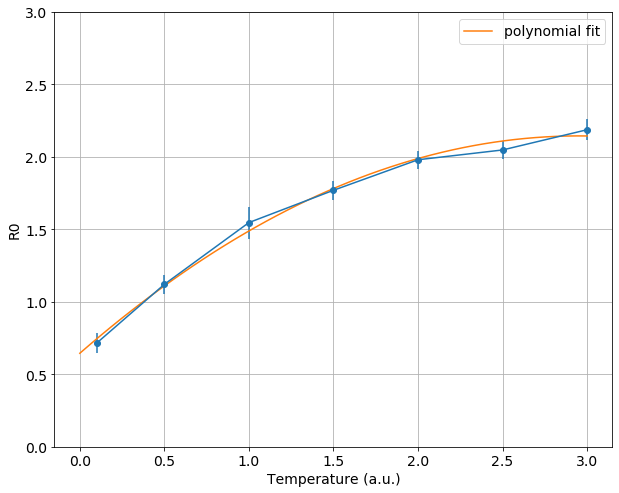

In [26]:
n = 50
x = np.linspace(0,max(temperatures),n)

(ar, br, cr) = np.polyfit(temperatures, r0mean, 2)
xr = np.polyval([ar, br, cr], x)

plt.figure(figsize=(10, 8))
plt.errorbar(temperatures,r0mean,xerr=0.,yerr=r0rms,fmt='o-')
plt.plot(x,xr,label='polynomial fit')

plt.legend()
plt.grid(True)
plt.ylim(0.,3.)
plt.xlabel("Temperature (a.u.)")
plt.ylabel("R0")
plt.show()

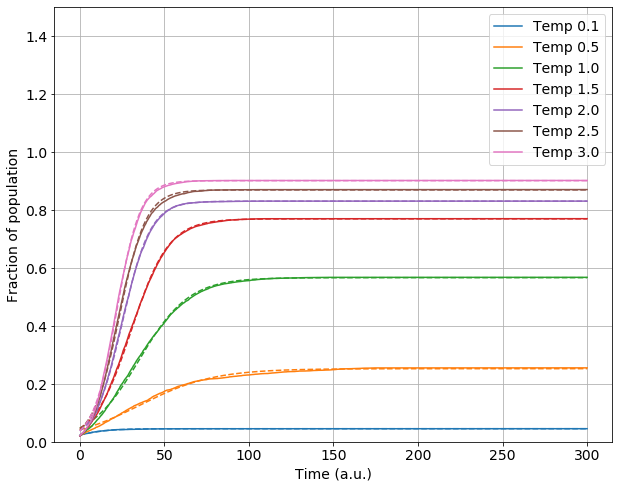

In [36]:
from scipy.optimize import curve_fit

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

x = np.linspace(0, 300, int(300/dt))
plt.figure(figsize=(10, 8))
for t0 in temperatures:
    fit = curve_fit(logistic_model,times[t0],totalInfected[t0],p0=[2,20,0.7])

    bestFit = [fit[0][i] for i in range(3)]
    errors = [np.sqrt(fit[1][i][i]) for i in range(3)]

    #print("temperature {:.1f}".format(t0))
    #print(bestFit)
    #print(errors)

    p0=plt.plot(times[t0],totalInfected[t0],label="Temp {:.1f}".format(t0))
    plt.plot(x, logistic_model(x,fit[0][0],fit[0][1],fit[0][2]),"--",color=p0[0].get_color())

plt.legend()
plt.grid(True)
plt.ylim(0,1.5)
plt.xlabel("Time (a.u.)")
plt.ylabel("Fraction of population")
#plt.yscale('log')
plt.show()